In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
toy_path = os.path.join(cwd, '..', 'tools', 'toy_examples_utils')
sampling_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
#models_5d_path = os.path.join(cwd, '..', 'models_5d_gaussians', 'jensen_minimax')
#models_5d_path = os.path.join(cwd, '..', 'models_5d_gaussians', 'wasserstein')
models_5d_path = os.path.join(cwd, '..', 'models_5d_gaussians', 'wasserstein_2')
#sys.path.append(api_path)
sys.path.append(toy_path)
sys.path.append(sampling_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from toy_examples_utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)

from general_utils import DotDict

from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          xtry_langevin_sampling,
                          tempered_transitions_sampling,
                          gan_energy,
                          Gaussian_mixture,
                          IndependentNormal,
                          )
import importlib
train_jensen = False
if train_jensen:
    module_name =  'params_5d_gaussians_jensen'
else:
    module_name =  'params_5d_gaussians_wasserstein' 

params_module = importlib.import_module(module_name)
random_seed = params_module.random_seed
num_samples_in_cluster = params_module.num_samples_in_cluster
dim = params_module.dim
num_gaussian_per_dim = params_module.num_gaussian_per_dim
coord_limits = params_module.coord_limits
sigma = params_module.sigma 
train_dataset_size = params_module.train_dataset_size
n_dim = params_module.n_dim
n_layers_d = params_module.n_layers_d
n_layers_g = params_module.n_layers_g
n_hid_d = params_module.n_hid_d
n_hid_g = params_module.n_hid_g
n_out = params_module.n_out
mode = params_module.mode
n_calib_pts = params_module.n_calib_pts
device = params_module.device

from metrics import Evolution

In [4]:
from pathlib import Path
figpath = Path('../figs')

# 5D Gaussians, true target

In [5]:
X_train = prepare_gaussians(num_samples_in_cluster = num_samples_in_cluster, 
                            dim = dim, 
                            num_gaussian_per_dim = num_gaussian_per_dim, 
                            coord_limits = coord_limits, 
                            sigma = sigma,
                            random_seed = random_seed)

In [6]:
target_args = DotDict()
target_args.device = device
target_args.num_gauss = num_gaussian_per_dim ** dim


###create points
coords_per_dim = np.linspace(-coord_limits, 
                             coord_limits, 
                             num = num_gaussian_per_dim)
copy_coords = list(np.tile(coords_per_dim, (dim, 1)))
centers = np.array(np.meshgrid(*copy_coords), dtype = np.float64).T.reshape(-1, dim)

coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor(centers[i]).to(device) for i in range(centers.shape[0])]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(dim, dtype = torch.float64).to(device)]*target_args.num_gauss
target_args.dim = dim
true_target = Gaussian_mixture(target_args).log_prob

loc = torch.zeros(dim).to(device)
scale = torch.ones(dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal_5d = IndependentNormal(proposal_args)

In [7]:
evols_target = dict()

In [8]:
%autoreload

In [11]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0).cpu(), sigma=sigma)#, scaler=scaler)

grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 1
batchsize = batch_size_sample // n_batches
X_langevin, zs = langevin_sampling(true_target, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize)

every = 10
zs_small = zs[0, ::every]

Xs_gen = zs_small
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols_target['ULA'] = evol

  0%|          | 0/1 [02:44<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
proj_1 = 0
proj_2 = 1
title_langevin = "Training and Langevin samples on target"
label_langevin = f'Langevin samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_langevin, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_langevin,
                          fake_label = label_langevin,
                          path_to_save=Path(figpath, '5d_known_target_ula.pdf'))

In [ ]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0).cpu(), sigma=sigma)#, scaler=scaler)

grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 500
n_batches = 1
acceptance_rule = 'Hastings'
batchsize = batch_size_sample // n_batches
X_mala_hastings, zs = mala_sampling(true_target, 
                                    proposal_5d, 
                                    n_steps, 
                                    grad_step, 
                                    eps_scale, 
                                    batch_size_sample, 
                                    batchsize,
                                    acceptance_rule = acceptance_rule)

every = 10
zs = zs[0, ::every]

Xs_gen = zs
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols_target['MALA,  MH'] = evol

In [ ]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Hastings'
title_mala_hastings = f"Training and MALA/{acceptance_rule} samples on target"
label_mala_hastings = f'MALA/{acceptance_rule} samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_hastings, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_hastings,
                          fake_label = label_mala_hastings,
                          path_to_save=Path(figpath, '5d_known_target_mala_hastings.pdf'))

In [ ]:
grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Barker'
batchsize = batch_size_sample // n_batches
X_mala_barker, zs = mala_sampling(true_target, 
                                  proposal_5d, 
                                  n_steps, 
                                  grad_step, 
                                  eps_scale, 
                                  batch_size_sample, 
                                  batchsize,
                                  acceptance_rule = acceptance_rule)

In [ ]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Barker'
title_mala_barker = f"Training and MALA/{acceptance_rule} samples on target"
label_mala_barker = f'MALA/{acceptance_rule} samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_barker, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_barker,
                          fake_label = label_mala_barker,
                          path_to_save=Path(figpath, '5d_known_target_mala_barker.pdf'))

In [ ]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0).cpu(), sigma=sigma)#, scaler=scaler)

grad_step = 1e-4
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 500
n_batches = 1
batchsize = batch_size_sample // n_batches
N = 2
X_xtry_langevin, zs = xtry_langevin_sampling(true_target, 
                                             proposal_5d, 
                                             n_steps, 
                                             grad_step, 
                                             eps_scale, 
                                             N,
                                             batch_size_sample, 
                                             batchsize)

every = 10
zs = zs[0, ::every]

Xs_gen = zs
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols_target[f'X-Try, N={N}'] = evol

In [ ]:
proj_1 = 0
proj_2 = 1
title_xtry_langevin = "Training and X-try samples on target"
label_xtry_langevin = f'X-try samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}, N = {N}'

plot_fake_data_projection(fake = X_xtry_langevin, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_xtry_langevin,
                          fake_label = label_xtry_langevin,
                          path_to_save=Path(figpath, '5d_known_target_xtry.pdf'))

In [ ]:
name = 'True target for 5D Gaussians'
plot_chain_metrics(every = every, name = name, **evols_target, savepath=Path(figpath, '5d_known_target_chain_metrics.pdf'))

# 5D Gaussians, GANs

In [9]:
evols = dict()

In [10]:
G_5d = Generator_fc(n_dim=n_dim, 
                    n_layers=n_layers_g,
                    n_hid=n_hid_g,
                    n_out=n_out,
                    non_linear=nn.ReLU(),
                    device=device)
D_5d = Discriminator_fc(n_in=n_dim, 
                        n_layers=n_layers_d,
                        n_hid=n_hid_d,
                        non_linear=nn.ReLU(),
                        device=device)

In [11]:
discriminator_regexp = os.path.join(models_5d_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_5d_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]
G_5d.load_state_dict(torch.load(generator_name, map_location=device))
D_5d.load_state_dict(torch.load(discriminator_name, map_location=device))

<All keys matched successfully>

In [12]:
G_5d = G_5d.to(device)
D_5d = D_5d.to(device)
for p in G_5d.parameters():  
    p.requires_grad = False
for p in D_5d.parameters():  
    p.requires_grad = False

In [12]:
batch_size_sample = 5000
fake_generator = G_5d.sampling(batch_size_sample).data.cpu().numpy()
proj_1 = 0
proj_2 = 1
path_to_plot_generator = None

title_generator = "Training and generated samples"
fake_label_generator = "samples by G"

plot_fake_data_projection(fake = fake_generator, 
                          X_train = X_train,
                          #path_to_save = path_to_plot_generator, 
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_generator,
                          fake_label = fake_label_generator,
                          path_to_save=Path(figpath, '5d_gan.pdf'))

In [ ]:
n_calib_pts = 6*batch_size_sample
type_calibrator = 'iso'
normalize_to_0_1 = True
X_mh = mh_sampling(X_train, 
                   G_5d, 
                   D_5d, 
                   G_5d.device, 
                   n_calib_pts, 
                   batch_size_sample=batch_size_sample,
                   normalize_to_0_1=normalize_to_0_1,
                   type_calibrator=type_calibrator)

title_mhgan = "Training and MHGAN samples"
label_mhgan = 'MHGAN samples'

plot_fake_data_projection(fake = X_mh, 
                          X_train = X_train,
                          path_to_save = path_to_plot_generator, 
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mhgan,
                          fake_label = label_mhgan)

In [13]:
n_dim = G_5d.n_dim
loc = torch.zeros(n_dim).to(G_5d.device)
scale = torch.ones(n_dim).to(G_5d.device)
normal = Normal(loc, scale)
normalize_to_0_1 = True 
log_prob = True

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal_5d = IndependentNormal(proposal_args)

target_gan_5d = partial(gan_energy, 
                        generator = G_5d, 
                        discriminator = D_5d, 
                        proposal = proposal_5d, #normal,
                        normalize_to_0_1 = normalize_to_0_1,
                        log_prob = log_prob)

In [14]:
grad_step = 1e-3
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 2000
n_batches = 10
batchsize = batch_size_sample // n_batches
X_langevin_gan, zs = langevin_sampling(target_gan_5d, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize)
X_langevin_gan = torch.FloatTensor(X_langevin_gan).to(proposal_5d.device)
X_langevin_gan = G_5d(X_langevin_gan).data.cpu().numpy()

 60%|██████    | 6/10 [03:00<02:00, 30.07s/it]


KeyboardInterrupt: 

In [ ]:
proj_1 = 0
proj_2 = 1
title_langevin_gan = "Training and Langevin samples on GAN energy"
label_langevin_gan = f'Langevin samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_langevin_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_langevin_gan,
                          fake_label = label_langevin_gan,
                          path_to_save=Path(figpath, f'5d_gan_ula_{proj_1}_{proj_2}.pdf'))

In [ ]:
proj_1 = 2
proj_2 = 3
title_langevin_gan = "Training and Langevin samples on GAN energy"
label_langevin_gan = f'Langevin samples,  noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_langevin_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_langevin_gan,
                          fake_label = label_langevin_gan,
                          path_to_save=Path(figpath, f'5d_gan_ula_{proj_1}_{proj_2}.pdf'))

In [14]:
batch_size_sample = 5000

In [15]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0).cpu(), sigma=sigma)#, scaler=scaler)

n_steps = 2000
every = 50
grad_step = 1e-3
eps_scale = 1e-2
z_last_np, zs = langevin_sampling(target_gan_5d, 
                                   proposal_5d,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)#,
                               #n_batches = n_batches)

zs = zs[0, ::every]

Xs_gen = G_5d(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols['ULA'] = evol

100%|██████████| 1/1 [04:27<00:00, 267.21s/it]


In [ ]:
grad_step = 1e-3
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 10
acceptance_rule = 'Hastings'
batchsize = batch_size_sample // n_batches
X_mala_hastings_gan, zs = mala_sampling(target_gan_5d, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize,
                                   acceptance_rule = acceptance_rule)
X_mala_hastings_gan = torch.FloatTensor(X_mala_hastings_gan).to(proposal_5d.device)
X_mala_hastings_gan = G_5d(X_mala_hastings_gan).data.cpu().numpy()

In [ ]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Hastings'
title_mala_hastings_gan = f"Training and MALA/{acceptance_rule} samples on GAN energy"
label_mala_hastings_gan = f'MALA/{acceptance_rule} samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_hastings_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_hastings_gan,
                          fake_label = label_mala_hastings_gan,
                          path_to_save=Path(figpath, f'5d_gan_mala_hastings_{proj_1}_{proj_2}.pdf'))

In [ ]:
proj_1 = 2
proj_2 = 3
acceptance_rule = 'Hastings'
title_mala_hastings_gan = f"Training and MALA/{acceptance_rule} samples on GAN energy"
label_mala_hastings_gan = f'MALA/{acceptance_rule} samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_hastings_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_hastings_gan,
                          fake_label = label_mala_hastings_gan,
                          path_to_save=Path(figpath, f'5d_gan_mala_hastings_{proj_1}_{proj_2}.pdf'))

In [16]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0).cpu(), sigma=sigma)#, scaler=scaler)

n_steps = 2000
every = 50
grad_step = 1e-3
eps_scale = 1e-2
z_last_np, zs = mala_sampling(target_gan_5d, 
                                   proposal_5d,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               acceptance_rule='Hastings')#,
                               #n_batches = n_batches)

zs = zs[0, ::every]

Xs_gen = G_5d(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols['MALA,  MH'] = evol

100%|██████████| 1/1 [07:30<00:00, 450.39s/it]


In [ ]:
grad_step = 1e-2
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 10
acceptance_rule = 'Barker'
batchsize = batch_size_sample // n_batches
X_mala_barker_gan, zs = mala_sampling(target_gan_5d, 
                                   proposal_5d, 
                                   n_steps, 
                                   grad_step, 
                                   eps_scale, 
                                   batch_size_sample, 
                                   batchsize,
                                   acceptance_rule = acceptance_rule)
X_mala_barker_gan = torch.FloatTensor(X_mala_barker_gan).to(proposal_5d.device)
X_mala_barker_gan = G_5d(X_mala_barker_gan).data.cpu().numpy()

In [ ]:
proj_1 = 0
proj_2 = 1
acceptance_rule = 'Barker'
title_mala_barker_gan = f"Training and MALA/{acceptance_rule} samples on GAN energy"
label_mala_barker_gan = f'MALA/{acceptance_rule} samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}'

plot_fake_data_projection(fake = X_mala_barker_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_mala_barker_gan,
                          fake_label = label_mala_barker_gan,
                          path_to_save=Path(figpath, f'5d_gan_mala_barker_{proj_1}_{proj_2}.pdf'))

In [ ]:
grad_step = 1e-2
batch_size_sample = 5000
eps_scale = (grad_step * 2) ** 0.5
n_steps = 1000
n_batches = 10
batchsize = batch_size_sample // n_batches
N = 2
X_xtry_langevin_gan, zs = xtry_langevin_sampling(target_gan_5d, 
                                             proposal_5d, 
                                             n_steps, 
                                             grad_step, 
                                             eps_scale, 
                                             N,
                                             batch_size_sample, 
                                             batchsize)

In [ ]:
X_xtry_langevin_gan = torch.FloatTensor(X_xtry_langevin_gan).to(proposal_5d.device)
X_xtry_langevin_gan = G_5d(X_xtry_langevin_gan).data.cpu().numpy()

In [ ]:
title_xtry_langevin_gan = "Training and X-Try-Langevin samples on GAN energy"
label_xtry_langevin_gan = f'X-Try-Langevin samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}, N = {N}'

plot_fake_data_projection(fake = X_xtry_langevin_gan, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title_xtry_langevin_gan,
                          fake_label = label_xtry_langevin_gan,
                          path_to_save=Path(figpath, f'5d_gan_xtry_{proj_1}_{proj_2}.pdf'))

In [17]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0).cpu(), sigma=sigma)#, scaler=scaler)

n_steps = 2000
every = 50
N = 2
grad_step = 1e-3
eps_scale = 1e-2
z_last_np, zs = xtry_langevin_sampling(target_gan_5d, 
                                   proposal_5d,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               N = N)#,
                               #n_batches = n_batches)

zs = zs[0, ::every]

Xs_gen = G_5d(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'X-Try, N={N}'] = evol

100%|██████████| 1/1 [09:42<00:00, 582.17s/it]


In [18]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0).cpu(), sigma=sigma)#, scaler=scaler)

n_steps = 2000
batch_size_sample = 5000
every = 50

grad_step = 1e-3
eps_scale = 1e-2

betas = np.linspace(1., 0.05, 5)
z_last_np, zs = tempered_transitions_sampling(target_gan_5d, 
                                   proposal_5d,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               betas=betas)

zs = zs[0, ::every]

Xs_gen = G_5d(torch.FloatTensor(zs).to(device)).detach().cpu().numpy()
#Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'Tempered transitions'] = evol

100%|██████████| 1/1 [30:14<00:00, 1814.64s/it]


In [19]:
proj_1 = 0 
proj_2 = 1

X_gen = Xs_gen[20]

title = "Training and Tempered samples on GAN energy"
label = f'Tempered samples, noise std = {round(eps_scale, 3)}, lr = {grad_step}, N = {N}'

plot_fake_data_projection(fake = X_gen, 
                          X_train = X_train,
                          proj_1 = proj_1, 
                          proj_2 = proj_2,
                          title = title,
                          fake_label = label,
                          path_to_save=Path(figpath, f'5d_gan_Tempered_{proj_1}_{proj_2}.pdf'))

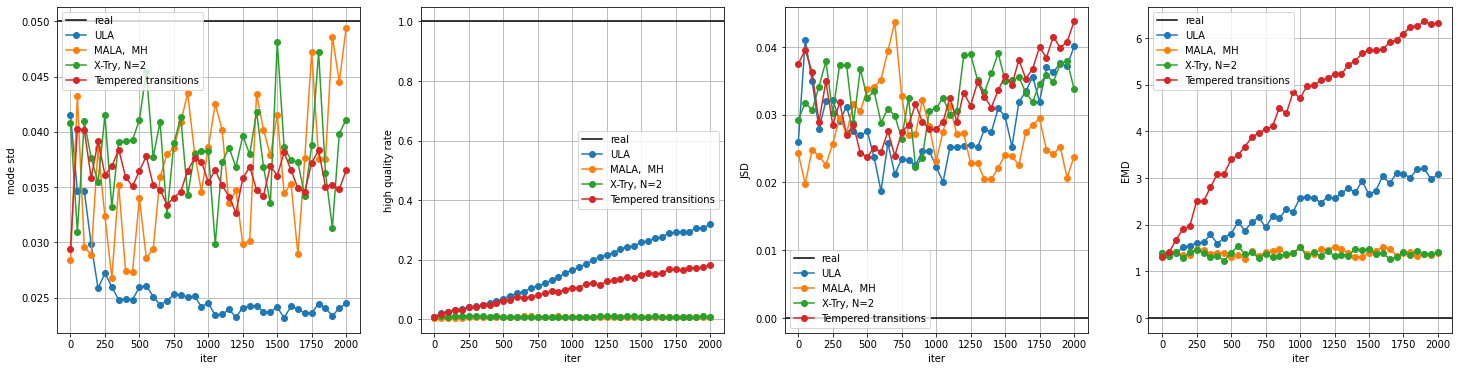

In [20]:
plot_chain_metrics(**evols, savepath=Path(figpath, '5d_gan_chain_metrics.pdf'))